In [ ]:
# default_exp tastenet_mnl

# tastenet_mnl

> tastenet_mnl explore.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def say_hello(to):
    "Say hello to somebody"
    return f'Hello {to}!'

#### models

In [ ]:
#export

import torch
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F

def get_act(nl_func):
    if nl_func=="tanh":
        return nn.Tanh()
    elif nl_func == "relu":
        return nn.ReLU()
    elif nl_func == "sigmoid":
        return nn.Sigmoid()
    else:
        return None
    
class ChoiceFlex(nn.Module):
    def __init__(self, args):
        super(ChoiceFlex, self).__init__()
        self.params_module = TasteParams(args.layer_sizes, args)
        self.util_module = Utility(args)
        self.args = args
    
    def forward(self, z, x, av):
        b = self.params_module(z) # taste parameters, (N,8)
        b = self.constraints(b)  ## this is another way to include constraint:  using transformation to include constraints 
        v = self.util_module(x,b) #no softmax here 
        exp_v = torch.exp(v)
        exp_v_av = exp_v * av
        
        prob = exp_v_av/exp_v_av.sum(dim=1).view(-1,1) # prob (N,J)
        
        return prob, None  
    
    def constraints(self,b):
        '''
            Put transformation for the sake of constraints on the value of times 
        '''
        if self.args.transform=='relu':
            return torch.cat([-F.relu(-b[:,:-3]),b[:,-3:]],dim=1)
        elif self.args.transform == 'exp':
            return torch.cat([-torch.exp(-self.args.mu * b[:,:-3]),b[:,-3:]],dim=1) # the last 3 dim of b are under constraints
        else:
            return b
    
    def getParameters(self):
        '''
        get coef and bias of the TasteParams of the model 
        '''
        count = 0
        bias = []
        coef = []
        for params in self.parameters():
            if count % 2==0:
                coef.append(params)
            else:
                bias.append(params)
            count += 1
        return coef, bias
    
    def L2Norm(self):
        '''
        L2 norm, not including bias
        '''
        coef, bias = self.getParameters()
        norm = torch.zeros(1)
        for params in coef:
            norm += (params**2).sum()
        return norm            

    def L1Norm(self):
        '''
        L1 norm, not including bias
        '''
        coef, bias = self.getParameters()
        norm = torch.zeros(1)
        for params in coef:
            norm += (torch.abs(params).sum())
        return norm

class Utility(nn.Module):
    def __init__(self, args):
        super(Utility, self).__init__()
        self.args = args
        self.index = OrderedDict(zip(['TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_HE', 'SM_HE', 'SM_SEATS', 'TRAIN_ASC', 'SM_ASC'], range(8)))

        
    def forward(self, x, b):
        '''
        x: attributes of each alternative, 
           including the intercept (N,K+1,J)  J alternatives, each have K+1 attributes including 1 for intercept. 
        b: taste parameters (K+1,J)  Some paramters are constant, some come from neural network hidden layer.  
        '''
        index = self.index
        N = len(b)        
        # last hidden nodes correspond to b_names
        v = torch.zeros(N,3)        
        v[:,0] = torch.ones(N) * b[:,index["TRAIN_ASC"]] + x["TRAIN"]["TRAIN_TT"]*b[:,index["TRAIN_TT"]] + x["TRAIN"]["TRAIN_HE"]*b[:,index["TRAIN_HE"]] - x["TRAIN"]["TRAIN_CO"]
        v[:,1] = torch.ones(N) * b[:,index["SM_ASC"]] + x["SM"]["SM_TT"]*b[:,index["SM_TT"]] + x["SM"]["SM_HE"]*b[:,index["SM_HE"]] + x["SM"]["SM_SEATS"]*b[:,index["SM_SEATS"]] - x["SM"]["SM_CO"]
        v[:,2] = x["CAR"]["CAR_TT"]*b[:,index["CAR_TT"]] - x["CAR"]["CAR_CO"]
        
        return v

class TasteParams(nn.Module):
    '''
    Network for tastes
    Structure: MLP
    '''
    def __init__(self, layer_sizes, args):
        super(TasteParams, self).__init__()
        self.seq = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])): #layer_sizes = [input_size,..., K(number of parameters)]
            self.seq.add_module(name="L%i"%(i+1), module=nn.Linear(in_size, out_size, bias=True))
            if i<len(layer_sizes)-2:
                self.seq.add_module(name="A%i"%(i+1), module=get_act(args.act_func))
        self.args = args
        
    def forward(self,z):
        '''
        Parameters:
            z: (N,D) # batch size, input dimension
        Returns:
            V: (N,K) # taste parameters 
        '''
        N,D = z.size()
        return self.seq(z) # (N,K) 

#### data_utils

In [ ]:
import pickle
from torch.utils.data import Dataset
import torch
import numpy as np 

class ChoiceDataset(Dataset):
    """Choice dataset"""

    def __init__(self, data_path, data_file):
        """
        Parameters:
            data_file (string): name of data pickle file
        """
        data = pickle.load(open(data_path + "/" + data_file, "rb"))
        
        self.x = torch.Tensor(data["x"])
        self.x_names = data["x_names"]
        self.N = len(self.x)
        
        dic_attr = \
        {"TRAIN": ["TRAIN_TT", "TRAIN_HE", "TRAIN_CO"], \
         "SM": ["SM_TT", "SM_HE", "SM_CO", "SM_SEATS"],\
         "CAR": ["CAR_TT", "CAR_CO"]}
        
        self.x_dict = {}
        for mode in dic_attr:
            self.x_dict[mode] = {}
            for attr in dic_attr[mode]:
                self.x_dict[mode].update({attr: getAttribute(self.x, self.x_names, attr)})
        
        self.y = torch.LongTensor(data["y"])-1 # N
        
        # Availability 
        self.av = torch.cat([torch.ones(self.N,2),torch.Tensor(data["car_av"]).view(self.N,1)], dim=1) # (N,3) av for all modes 
        
        # all z 
        self.z_all_names = data['z_names']
        self.z_levels = data['z_levels']
        self.z_all = torch.Tensor(data['z']) # N,D socio-demo variables

        # select z
        self.z_names = ["MALE_1", "AGE_1", "AGE_2", "AGE_3", "AGE_4", \
               "INCOME_1", "INCOME_2", "INCOME_3", "FIRST_1", "WHO_1", "WHO_2", \
               "PURPOSE_1", "PURPOSE_2", "PURPOSE_3", "LUGGAGE_1", "LUGGAGE_2", "GA_1"]
        self.z = selectZ(self.z_all, self.z_names, self.z_all_names)
        
        _, self.D = self.z.size() # z size = (N,D)

        
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        '''
        Get the sample given its idx in the list 
        '''
        x = {} # x is a dictionary!
        for mode in self.x_dict:
            x[mode] = {}
            for name in self.x_dict[mode]:
                x[mode][name] = self.x_dict[mode][name][idx]
        return {"x": x, "y": self.y[idx], "z":self.z[idx], "av": self.av[idx]}
    
def getAttribute(x, x_names, name):
    return x[:,x_names.index(name)]
    
def selectZ(z,z_selected, z_names):
    ind = []
    for var in z_selected:
        ind.append(z_names.index(var))
    return z[:,np.array(ind).astype(int)]







In [ ]:
####Testing
   
data_path = './data'
data_file = 'swissmetro_all.pkl'
ds = ChoiceDataset(data_path, data_file)
print(ds.x.size())
print(ds.z.size())


KeyError: 'x'

#### Data preparation

In [ ]:
# Convert .dat to .pck
import pandas as pd
df = pd.read_csv('./data/swissmetro.dat', sep='	')
df.shape

In [ ]:
# Remove unknown age (6)
df['AGE'].value_counts
df = df[df['AGE'] != 6]
# Remove "other" trip purpose (9)
df = df[df['PURPOSE'] != 9]
# Remove "unknown" choice (0)
df = df[df['CHOICE'] != 0]
df.shape

In [ ]:
# Generate train, valid, test (70%,15%,15%)

(10692, 28)

In [ ]:
# Save to pickle file
df.to_pickle('./data/swissmetro_all.pkl')

In [ ]:
data = pickle.load(open('./data/swissmetro_all.pkl', "rb"))

In [ ]:
data

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,1,1,0,1,1,0,3,...,112,48,120,63,52,20,0,117,65,2
1,2,0,1,1,1,0,1,1,0,3,...,103,48,30,60,49,10,0,117,84,2
2,2,0,1,1,1,0,1,1,0,3,...,130,48,60,67,58,30,0,117,52,2
3,2,0,1,1,1,0,1,1,0,3,...,103,40,30,63,52,20,0,72,52,2
4,2,0,1,1,1,0,1,1,0,3,...,130,36,60,63,42,20,0,90,84,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723,3,1,1,1192,4,1,7,1,0,5,...,148,13,30,93,17,30,0,156,56,2
10724,3,1,1,1192,4,1,7,1,0,5,...,148,12,30,96,16,10,0,96,70,3
10725,3,1,1,1192,4,1,7,1,0,5,...,148,16,60,93,16,20,0,96,56,3
10726,3,1,1,1192,4,1,7,1,0,5,...,178,16,30,96,17,30,0,96,91,2


In [ ]:
type(data[])

pandas.core.frame.DataFrame

In [ ]:
dic_attr = \
{"TRAIN": ["TRAIN_TT", "TRAIN_HE", "TRAIN_CO"], \
 "SM": ["SM_TT", "SM_HE", "SM_CO", "SM_SEATS"],\
 "CAR": ["CAR_TT", "CAR_CO"]}

x_dict = {}
for mode in dic_attr:
    print(mode)
    x_dict[mode] = {}
    for attr in dic_attr[mode]:
        x_dict[mode].update({attr:attr})

TRAIN
SM
CAR


In [ ]:
x_dict

{'TRAIN': {'TRAIN_TT': 'TRAIN_TT',
  'TRAIN_HE': 'TRAIN_HE',
  'TRAIN_CO': 'TRAIN_CO'},
 'SM': {'SM_TT': 'SM_TT',
  'SM_HE': 'SM_HE',
  'SM_CO': 'SM_CO',
  'SM_SEATS': 'SM_SEATS'},
 'CAR': {'CAR_TT': 'CAR_TT', 'CAR_CO': 'CAR_CO'}}

In [ ]:
def getAttribute(x, x_names, name):
    return x[:,x_names.index(name)]

In [ ]:
{attr: getAttribute(self.x, self.x_names, attr)}

NameError: name 'self' is not defined

In [ ]:
import torch
def sampleZ(z_levels, N):
    '''
    Randomly generate N samples for input z
    Returns 
        z: (N,7) where 7 is the number of z(categorical)
    '''
    num_z = len(z_levels) # z dimension
    z = torch.zeros(N,num_z)
    i = 0
    for key in z_levels:
        z[:,i] = torch.randint(0, z_levels[key], size=(N,))
        i+=1
    return z

def cat2dummies(df_z, var, num_levels):
    '''
    Convert z to dummies 
    '''
    dmy = pd.get_dummies(df_z[var])
    dmy.columns = [var+str("_")+str(i) for i in range(num_levels)]
    df_z = pd.concat([df_z, dmy], axis=1)
    return df_z

import pandas as pd
def generateZInput(N_samples, z_levels):
    D = len(z_levels)
    z_samples = sampleZ(z_levels, N_samples)
    df_z = pd.DataFrame(z_samples.numpy(), columns = z_levels.keys())
    
    for var in z_levels:
        df_z = cat2dummies(df_z, var, z_levels[var])
    print(df_z.head())
    z_input = torch.Tensor(df_z[df_z.columns[D:]].values)
    return z_input


In [ ]:
z_levels = {'A':10,'B':5}
N = 100000

In [ ]:
zt = sampleZ(z_levels, N)
type(zt)

torch.Tensor

In [ ]:
zt.numpy()

array([[9., 3.],
       [5., 4.],
       [2., 1.],
       ...,
       [3., 0.],
       [0., 1.],
       [1., 4.]], dtype=float32)

<AxesSubplot:>

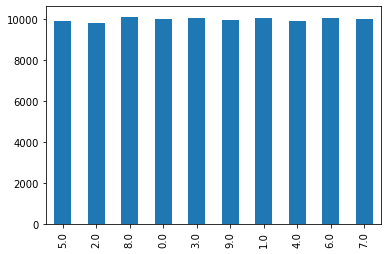

In [ ]:
import pandas as pd
df = pd.DataFrame(zt.numpy())
df[0].value_counts(sort=False).plot(kind='bar')

In [ ]:
zt.shape

torch.Size([100000, 2])

In [ ]:
ts = generateZInput(N, z_levels)

     A    B  A_0  A_1  A_2  A_3  A_4  A_5  A_6  A_7  A_8  A_9  B_0  B_1  B_2  \
0  0.0  3.0    1    0    0    0    0    0    0    0    0    0    0    0    0   
1  5.0  2.0    0    0    0    0    0    1    0    0    0    0    0    0    1   
2  4.0  2.0    0    0    0    0    1    0    0    0    0    0    0    0    1   
3  0.0  0.0    1    0    0    0    0    0    0    0    0    0    1    0    0   
4  7.0  4.0    0    0    0    0    0    0    0    1    0    0    0    0    0   

   B_3  B_4  
0    1    0  
1    0    0  
2    0    0  
3    0    0  
4    0    1  


In [ ]:
type(ts), ts.shape

(torch.Tensor, torch.Size([100000, 15]))

In [ ]:
ts[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
layer_sizes = [5, 3, 6, 7]
for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])): 
    #layer_sizes = [input_size,..., K(number of parameters)]
    print(in_size, out_size)

5 3
3 6
6 7


In [ ]:
layer_sizes[:-1]

[5, 3, 6]

In [ ]:
 layer_sizes[1:]

[3, 6, 7]

In [ ]:
torch.ones(N)

tensor([1., 1., 1.,  ..., 1., 1., 1.])